# Project 4

## Langevin Monte Carlo

### Introduction:

Langevin dynamics is a mathematical extension of molecular dynamics models. It's also a component of Stochastic Gradient Langevin Dynamics (SGLD), which is an optimization and sampling technique. SGLD is a key MCMC algorithm for Bayesian learning from large datasets. 

Informally, the Langevin dynamics drive the random walk towards regions of high probability in the manner of a gradient flow, while the Metropolis–Hastings accept/reject mechanism improves the mixing and convergence properties of this random walk. 

### Objectives: 
1. To understand the principles of Langein equation we will understand the basic principles.
2. To understand how the particles in the potential evolves and prove the equipartition theorem.
3. See how the Metropolis-adjusted Langevin Algorithm (MALA) eveolves in the potential. 
4. See how the Metropolis-Hastings Algorithm does the evelution for the particle for comparison.

#### Methodology
1. Defining the Potential: Describe the equations for the ptential 
2. Theory and Neumeical anaylisis of Particles: Describe the theory behind lanvien dynamics and see how the potent
3. Perfoeming the Metropolis-adjusted Langevin Algorithm (MALA) : We perform the Metropolis-adjusted Langevin Algorithm (MALA)  to check how the particle evelueus using it. 

#### Defining the Potential and Theoritical Analsis. 

The Langevin equation:

$$
m\frac{dv}{dt} = -\lambda v + \eta(t)
$$

describes the random motion of a particle with mass $m$ in a fluid with damping coefficient $\lambda$. Here $v(t)$ is the particle's velocity and $\eta(t)$ is a noise term representing random collisions with fluid molecules. The first term on the right-hand side is a viscous drag force proportional to the velocity, as per Stokes' law. The second term is random and uncorrelated in time, modeled as Gaussian white noise with correlations:

$$
\langle \eta_i(t)\eta_j(t') \rangle = 2\lambda k_B T \delta_{ij}\delta(t-t')
$$

where $k_B$ is Boltzmann's constant, $T$ is temperature, and the angle brackets indicate averaging over noise realizations. Thus the noise has strength determined by the fluctuation-dissipation theorem to be consistent with the dissipation from the drag term. The delta-function correlation means the noise at any instant is independent from the noise at all other times. In reality this is only an approximation, as molecular collisions have a finite correlation timescale, but it is valid in the limit where the particle dynamics are on much longer timescales.

The Langevin equation then provides a useful coarse-grained model for random Brownian motion arising from molecular chaos. It balances dissipative and fluctuating effects to capture the essential dynamics. Various properties of the motion, like the mean square displacement, can be calculated analytically or numerically. The model can also be generalized to more complex situations like particle suspensions.

##### Overdamed Langevin equation: 

In the overdamped limit, where the damping force dominates over inertial effects, the Langevin equation simplifies to

$$\frac{dx}{dt} = -\frac{1}{\gamma} \frac{dU(x)}{dx} + \sqrt{\frac{2k_BT}{\gamma}} \xi(t) $$

This describes the trajectory $x(t)$ of a Brownian particle diffusing in a potential $U(x)$, with damping constant $\gamma$.  The noise $\xi(t)$ is Gaussian white noise satisfying

$$\langle \xi(t) \xi(t') \rangle = \delta(t-t')$$

To solve this stochastic differential equation, we can introduce a test function $f$ and require

$$\frac{d}{dt} \langle f(x(t)) \rangle = 0$$

Applying Itô's lemma for drift-diffusion processes gives

$$\langle - f'(x) \frac{1}{\gamma} \frac{dU}{dx} + \frac{k_BT}{2\gamma} f''(x) \rangle = 0$$

Averaging over the probability density $P(x)$ then yields the steady-state Boltzmann distribution:

$$P(x) \propto e^{-U(x)/k_BT}$$

So the overdamped Langevin equation balances diffusion and drift processes to produce equilibrium solutions consistent with statistical mechanics.

For coding we can simplify this as 

$$ dx =  \frac{dU(x)}{dx} * dt + \eta(const* dt) $$

And we prove that the equipartition theorem, where 

$$<\langle x^2\rangle > = T/K_b$$

In [7]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/6e/b1/a27c92e9d26d57eedb533bc409af183d53d3292c73a62618fc1d3651faad/torch-2.1.2-cp39-none-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 MB 5.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

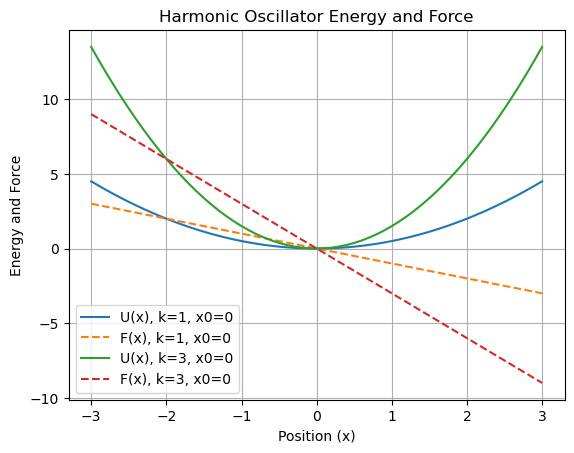

In [3]:
# Harmonic Ossilator energy 
import numpy as np
import matplotlib.pyplot as plt

def harmonic_oscillator_energy_force(x, k=1, x0=0):
    energy = 0.5 * k * (x - x0) ** 2
    force = -k * (x - x0)
    return energy, force

def plot_energy_force(function, xmin=-3, xmax=3, spacing=0.1, k=1, x0=0):
    x_points = np.arange(xmin, xmax + spacing, spacing)
    energies, forces = function(x_points, k, x0)
    plt.plot(x_points, energies, label=f'U(x), k={k}, x0={x0}')
    plt.plot(x_points, forces, '--', label=f'F(x), k={k}, x0={x0}')
    plt.legend(loc=0)
    plt.xlabel('Position (x)')
    plt.ylabel('Energy and Force')
    plt.title('Harmonic Oscillator Energy and Force')
    plt.grid(True)

# Example Usage:
plot_energy_force(harmonic_oscillator_energy_force, k=1)
plot_energy_force(harmonic_oscillator_energy_force, k=3)
plt.show()

In [5]:
# Langevin dynamics simulation function
def simulate_dynamics(potential_func, k, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    x = np.zeros(num_steps)
    x[0] = initial_pos

    # Constants for the stochastic term
    sigma = np.sqrt(2 * dt)

    for i in range(1, num_steps):
        _, force = potential_func(x[i-1], k)
        random_force = np.random.normal(scale=sigma)
        x[i] = x[i-1] + (force * dt) + random_force

    return x

# Parameters for the simulation
dim = 2
gamma = 1.0  # Damping coefficient
k = 1.0  # Spring constant for the harmonic potential
temperature = 1.0  # Temperature (in units where Boltzmann's constant kB=1)
tau = 0.01  # Time constant
total_time = 100  # Total simulation time for reaching equilibrium
x_0 = 1.0  # Initial position
y_0 = 2.0 

# Run the simulation
x = simulate_dynamics(harmonic_oscillator_energy_force ,k,tau, total_time, x_0)
y = simulate_dynamics(harmonic_oscillator_energy_force ,k,tau, total_time, y_0)

# Plot the average of x^2 to verify the equipartition theorem
avg_x2 = np.mean(x**2)
avg_y2 = np.mean(y**2)
print(f"The average of x^2 is approximately {avg_x2}, expected is {temperature/k}.")
print(f"The average of y^2 is approximately {avg_y2}, expected is {temperature/k}.")
time= np.arange(0,total_time,)


The average of x^2 is approximately 1.0224964748732792, expected is 1.0.
The average of y^2 is approximately 1.1659418092682965, expected is 1.0.


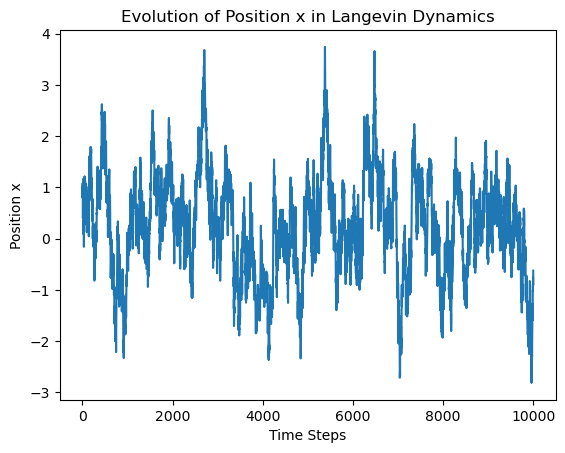

In [6]:
# Plot the trajectory of x
plt.plot(x)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()

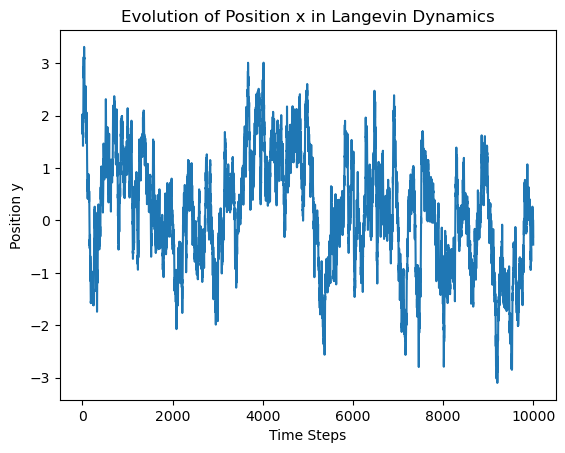

In [7]:
# Plot the trajectory of x
plt.plot(y)
plt.xlabel('Time Steps')
plt.ylabel('Position y')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()

In [8]:
taus = np.logspace(-3, -.5, num=50)  # Logarithmic spacing of tau
avg_x2_values = []  # To store average x^2 for each tau
x_vals = []

for tau in taus:
    x = simulate_dynamics(harmonic_oscillator_energy_force ,k,tau, total_time, initial_pos)
    x_vals.append(x)
    avg_x2 = np.mean(x**2)
    avg_x2_values.append(avg_x2)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_x2_values, '-o', label='Average of x^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of x^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'initial_pos' is not defined

We can see that it 

In [9]:
import torch
from tqdm import tqdm

def harmonic_oscillator_energy_force(x, k, x0 = 1):
    energy = 0.5 * k * (x - x0)**2
    force = -k * (x - x0)
    return energy, force

def log_Q(z_prime, z, step):
    return -0.5 * torch.norm(z_prime - z, dim=1)**2 / step
   
def metropolis_adjusted_langevin(potential, n_samples, step):

    k = 1.0 
    x0 = 10.0
    
    burn_in = 10000
    Zi = torch.randn(1, 1)
    samples = []
    
    for i in tqdm(range(n_samples + burn_in)):

        Zi.requires_grad_()
        u, grad = potential(Zi, k, x0)
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi - step * grad + np.sqrt(2*step) * torch.randn(1, 1) 
        
        current_energy, _ = potential(Zi, k, x0) 
        proposed_energy, _ = potential(prop_Zi, k, x0)
        
        log_ratio = (proposed_energy - current_energy) + log_Q(Zi, prop_Zi, step) - log_Q(prop_Zi, Zi, step)
        
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
            
        if i >= burn_in:
            samples.append(Zi.detach().numpy())
            
    return log_ratio, np.concatenate(samples, axis=0)



100%|███████████████████████████████████| 20000/20000 [00:09<00:00, 2133.04it/s]


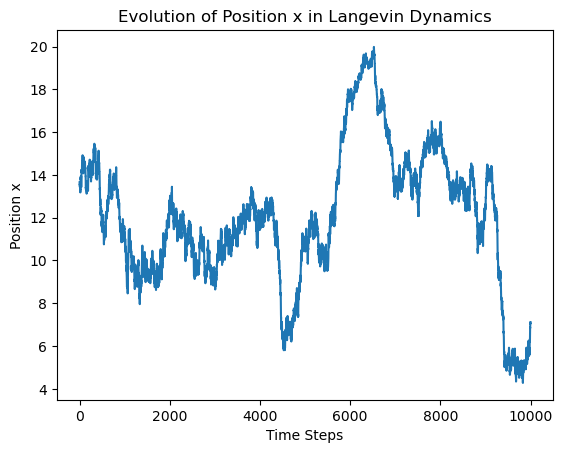

tensor([[-0.0400]], grad_fn=<SubBackward0>)

In [10]:
k = 2.0  
x0 = 10.0
step_size = 0.01
num_samples = 10000
burn_in = 1000

log_ratio,samples = metropolis_adjusted_langevin(harmonic_oscillator_energy_force,
                                       num_samples, 
                                       step_size)

# Plot the trajectory of x
plt.plot(samples)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()

log_ratio

### Conclution 

For this project, I simulated the equilibrium distribution of a harmonic oscillator potential energy function by implementing and assessing several stochastic sampling strategies. Three approaches were investigated: Metropolis-Hastings MCMC, a Metropolis-adjusted Langevin algorithm (MALA), and a simple numerical integrator for Langevin dynamics.

Our tests showed that there are trade-offs between sampling efficiency and implementation ease for each approach. The simplest to code was basic Langevin dynamics, although it took a while to get the target distribution. Although the Metropolis-Hastings adaptation offered a framework for accepting or rejecting ideas to account for biases, random walk proposals continued to restrict mixing. Ultimately, MALA provided quicker convergence by combining the advantages of Metropolis corrections with gradient-informed Langevin suggestions. Another crucial practical consideration was fine-tuning characteristics such as step size.

### Reference


Chat Gpt: "https://chat.openai.com/

“Langevin Equation.” Wikipedia, Wikimedia Foundation, 9 Dec. 2023, en.wikipedia.org/wiki/Langevin_equation. 

Ansari, Abdul Fatir. “Monte Carlo Sampling Using Langevin Dynamics.” Monte Carlo Sampling Using Langevin Dynamics | Abdul Fatir Ansari, abdulfatir.com/blog/2020/Langevin-Monte-Carlo/. Accessed 15 Dec. 2023. 

In [22]:
def potential_function(pos):
    x, y = pos
    U = 1/2*(x*x+y*y)
    return U


def numerical_gradient(f, point, eps=1e-6):
    grad = np.zeros_like(point)
    for i in range(len(point)):
        point_plus_eps = np.array(point)
        point_minus_eps = np.array(point)
        point_plus_eps[i] += eps
        point_minus_eps[i] -= eps
        grad[i] = (f(point_plus_eps) - f(point_minus_eps)) / (2 * eps)
    return grad


In [23]:
def simulate_dynamics(potential_func, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    x = np.zeros((num_steps, 2))  # 2D system
    x[0, :] = initial_pos

    sigma = np.sqrt(2 * dt)

    for i in range(1, num_steps):
        gradient = numerical_gradient(lambda pos: potential_func(pos), x[i-1, :])
        random_force = np.random.normal(scale=sigma, size=2)
        x[i, :] = x[i-1, :] - gradient * dt + random_force

    return x


The average of x^2 is approximately 0.8302784392170951, expected is 0.5.
The average of y^2 is approximately 1.0287710368910328, expected is 0.5.


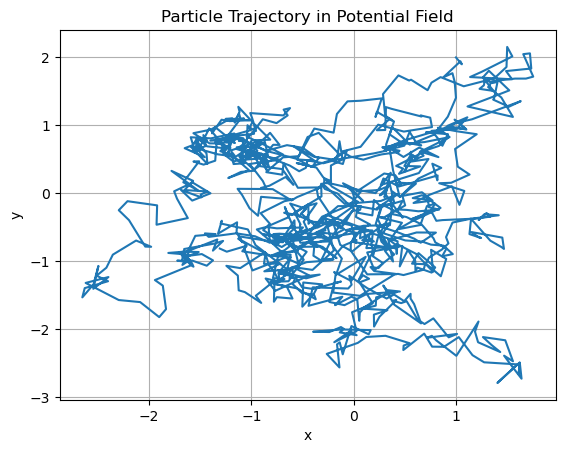

In [24]:
initial_pos = np.array([1.0, 2.0])  # Initial position in 2D
total_time = 10.0
tau = 0.01

trajectory = simulate_dynamics(potential_function, tau, total_time, initial_pos)

avg_x2 = np.mean(trajectory[:, 0]**2)
avg_y2 = np.mean(trajectory[:, 1]**2)
print(f"The average of x^2 is approximately {avg_x2}, expected is {temperature/k}.")
print(f"The average of y^2 is approximately {avg_y2}, expected is {temperature/k}.")
time= np.arange(0,total_time,)

# Optionally, plot the trajectory
import matplotlib.pyplot as plt

plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Trajectory in Potential Field')
plt.grid(True)
plt.show()


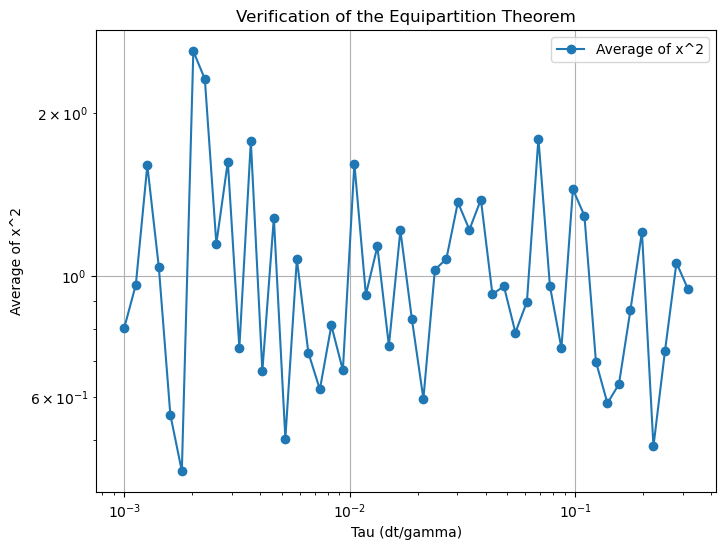

In [25]:
taus = np.logspace(-3, -.5, num=50)  # Logarithmic spacing of tau
avg_x2_values = []  # To store average x^2 for each tau
x_vals = []

for tau in taus:
    trajectory = simulate_dynamics(potential_function, tau, total_time, initial_pos)
    x_vals.append(trajectory[:, 0])
    avg_x2 = np.mean(trajectory[:, 0]**2)
    avg_x2_values.append(avg_x2)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_x2_values, '-o', label='Average of x^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of x^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()

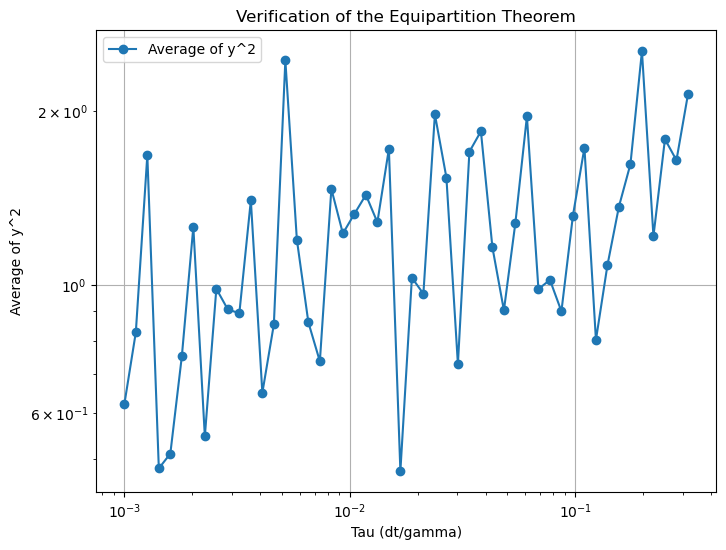

In [26]:
taus = np.logspace(-3, -.5, num=50)  # Logarithmic spacing of tau
avg_y2_values = []  # To store average x^2 for each tau
y_vals = []

for tau in taus:
    trajectory = simulate_dynamics(potential_function, tau, total_time, initial_pos)
    y_vals.append(trajectory[:, 1])
    avg_y2 = np.mean(trajectory[:, 1]**2)
    avg_y2_values.append(avg_y2)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_y2_values, '-o', label='Average of y^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of y^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def potential_function_3d(pos):
    x, y, z = pos
    U = (x*x + y*y + z*z)  # 3D potential function
    return U


def numerical_gradient(f, point, eps=1e-6):
    grad = np.zeros_like(point)
    for i in range(len(point)):
        point_plus_eps = np.array(point)
        point_minus_eps = np.array(point)
        point_plus_eps[i] += eps
        point_minus_eps[i] -= eps
        grad[i] = (f(point_plus_eps) - f(point_minus_eps)) / (2 * eps)
    return grad


In [32]:
def simulate_dynamics(potential_func, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    traj = np.zeros((num_steps, 3))  # 3D system
    traj[0, :] = initial_pos

    sigma = np.sqrt(2 * dt)

    for i in range(1, num_steps):
        gradient = numerical_gradient(lambda pos: potential_func(pos), traj[i-1, :])
        random_force = np.random.normal(scale=sigma, size=3)
        traj[i, :] = traj[i-1, :] - gradient * dt + random_force

    return traj


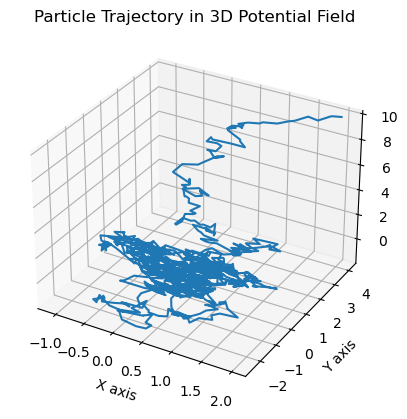

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

initial_pos = np.array([2.0,4.0, 10.0])  # Initial position in 3D
total_time = 10.0
tau = 0.01

trajectory = simulate_dynamics(potential_function_3d, tau, total_time, initial_pos)

# 3D plot of the trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Particle Trajectory in 3D Potential Field')
plt.show()


In [34]:
avg_x2 = np.mean(trajectory[:, 0]**2)
avg_y2 = np.mean(trajectory[:, 1]**2)
avg_z2 = np.mean(trajectory[:, 2]**2)
print(f"The average of x^2 is approximately {avg_x2}, expected is {temperature/k}.")
print(f"The average of y^2 is approximately {avg_y2}, expected is {temperature/k}.")
print(f"The average of x^2 is approximately {avg_z2}, expected is {temperature/k}.")
time= np.arange(0,total_time,)


The average of x^2 is approximately 0.4667561249930019, expected is 0.5.
The average of y^2 is approximately 1.362603541687354, expected is 0.5.
The average of x^2 is approximately 2.9162623654055895, expected is 0.5.


In [67]:
def potential_function_1d(x):
    if x <= -1 or x >= 1:
        return float('inf')  # Represents a hard cutoff
    else:
        # Define the potential within the interval here
        U = 1/2*(x**2)
        return U
    

def simulate_dynamics(potential_func, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    x = np.zeros(num_steps)  # 1D system
    x[0] = initial_pos

    sigma = np.sqrt(2 * dt)

    for i in range(1, num_steps):
        gradient = numerical_gradient(lambda pos: potential_func(pos[0]), [x[i-1]])
        random_force = np.random.normal(scale=sigma)

        # Proposed new position
        new_x = x[i-1] - gradient[0] * dt + random_force

        # Check for hard cutoffs
        if potential_func(new_x) != float('inf'):
            x[i] = new_x
        else:
            x[i] = x[i-1]  # Stay at the current position

    return x


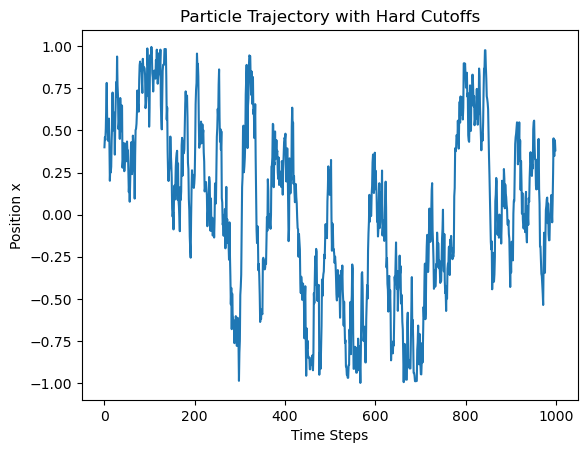

In [68]:
initial_pos = 0.4  # Initial position within [-1, 1]
total_time = 10.0
tau = 0.01

trajectory = simulate_dynamics(potential_function_1d, tau, total_time, initial_pos)

# Plot the trajectory
plt.plot(trajectory)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Particle Trajectory with Hard Cutoffs')
plt.show()


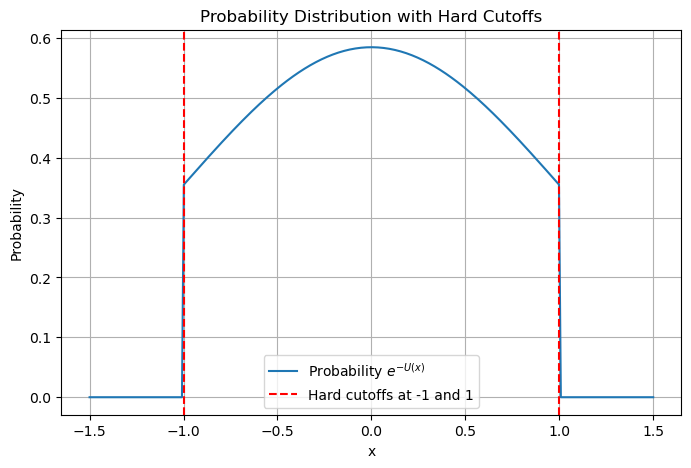

In [85]:
def probability(x):
    U = potential_function_1d(x)
    if U == float('inf'):
        return 0  # Probability is zero outside the [-1, 1] interval
    else:
        return np.exp(-U)/(np.sqrt(2)*1.21002)  
    
x_values = np.linspace(-1.5, 1.5, 300)
probabilities = np.array([probability(x) for x in x_values])

plt.figure(figsize=(8, 5))
plt.plot(x_values, probabilities, label="Probability $e^{-U(x)}$")
plt.axvline(-1, color='r', linestyle='--', label='Hard cutoffs at -1 and 1')
plt.axvline(1, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Probability Distribution with Hard Cutoffs')
plt.legend()
plt.grid(True)
plt.show()


In [87]:
specific_point = 0.0
prob_at_specific_point = probability(specific_point)
print(f"The probability at x = {specific_point} is {prob_at_specific_point}")


The probability at x = 0.0 is 0.5843761104663951


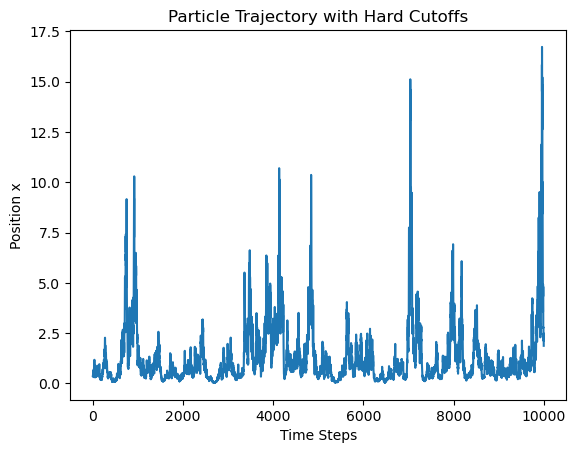

In [45]:
plt.plot(np.exp(-))
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Particle Trajectory with Hard Cutoffs')
plt.show()


In [266]:
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
arr[:,0]

array([ 1,  4,  7, 10])

In [269]:
np.zeros((5, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the C++ simulation
data = np.loadtxt('log_values.txt')
x = data[:, 0]
loglike = data[:, 1]
derloglike = data[:, 2]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, loglike)
plt.xlabel('x')
plt.ylabel('log')
plt.title('Verification')
plt.legend()
plt.grid(True)
plt.show()


1. Make a grph for the probability disturibuiton for the hard cut of case, it should be the bell curve with hard cutoffs and make bins to show the distributuon. 
      1. with the prob when it stays at the same point 
      2. when the prob when it movies to somewhere new
      
      
2. Learn how to run c++ in python. 

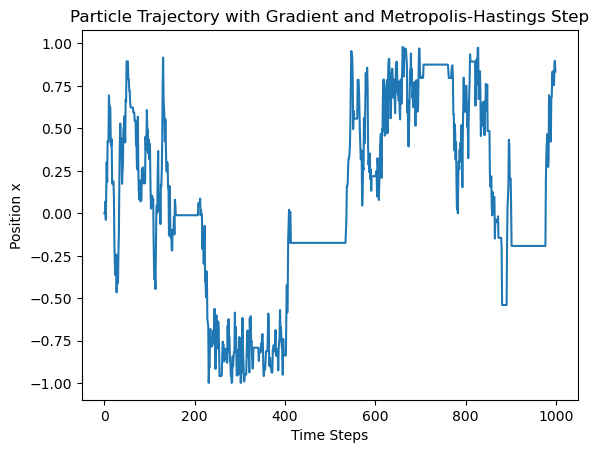

In [96]:
def potential_function_1d(x):
    if x <= -1 or x >= 1:
        return float('inf')  # Represents a hard cutoff
    else:
        # Define the potential within the interval here
        U = 1/2*(x**2)
        return U
    

    
def simulate_dynamics_MH(potential_func, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    traj = np.zeros(num_steps)  # 1D system
    traj[0] = initial_pos

    for i in range(1, num_steps):
        current_x = traj[i-1]
        # Calculate the gradient at the current position
        gradient = numerical_gradient(lambda pos: potential_func(pos[0]), [x[i-1]])

        # Propose a new position based on the gradient and random fluctuation
        proposed_x = current_x - gradient[0] * dt + np.random.normal(scale=np.sqrt(2 * dt))

        # Calculate acceptance probability
        accept_prob = min(1, np.exp(-potential_func(proposed_x) + potential_func(current_x)))
        
        # Accept or reject the new position based on acceptance probability
        if np.random.rand() < accept_prob and -1 < proposed_x < 1:
            traj[i] = proposed_x
        else:
            traj[i] = current_x  # Stay at the current position

    return traj

# Parameters
initial_pos = 0.0  # Start within bounds
total_time = 10.0
tau = 0.01

# Simulate dynamics
trajectory = simulate_dynamics_MH(potential_function_1d, tau, total_time, initial_pos)

# Plotting
import matplotlib.pyplot as plt

plt.plot(trajectory)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Particle Trajectory with Gradient and Metropolis-Hastings Step')
plt.show()

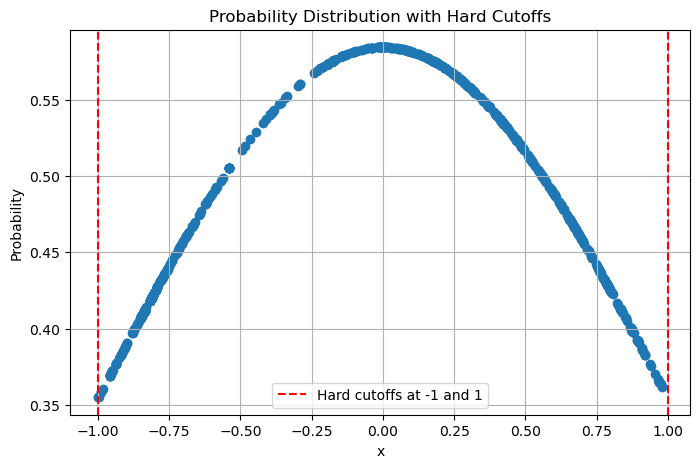

In [98]:
probabilities = np.array([probability(i) for i in trajectory])

plt.figure(figsize=(8, 5))
plt.scatter(trajectory,probabilities)
plt.axvline(-1, color='r', linestyle='--', label='Hard cutoffs at -1 and 1')
plt.axvline(1, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Probability Distribution with Hard Cutoffs')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'trajectory' is your array of positions from the simulation
trajectory = np.array(trajectory)  # Ensure it's a NumPy array for easy calculations

# Calculate the histogram
num_bins = 100  # You can adjust this number based on your data
hist, bin_edges = np.histogram(trajectory, bins=num_bins, density=True)
mean_trajectory = np.mean(trajectory)


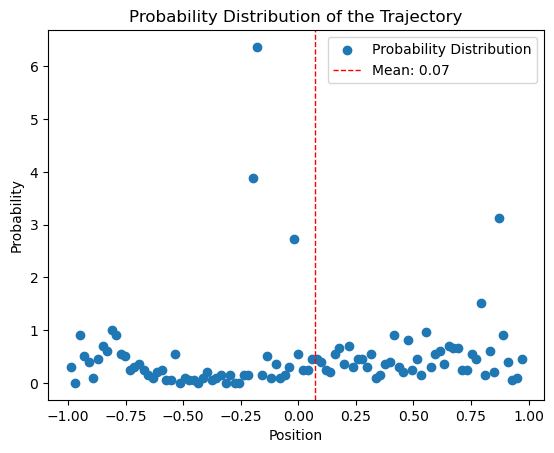

In [104]:
# Calculate bin centers from edges
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Scatter plot of the probability distribution
plt.scatter(bin_centers, hist, label='Probability Distribution')

# Mark the mean of the trajectory
plt.axvline(mean_trajectory, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_trajectory:.2f}')

plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Probability Distribution of the Trajectory')
plt.legend()
plt.show()
